In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


### **Data Loading & Description**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict, GridSearchCV,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier, AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score


In [3]:
df= pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')


In [4]:
df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [5]:
df.shape

(13636, 15)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


We can notice two key features from this data description:

1) It seems that only **Recipe_Review** column has null values.

2) Our data has mostly **numerical** data type, some of the features however are of ordinal data type.

Let's explore further to understand the data in a better way.

### **Descriptive Statistics and Exploratory Data Analysis**

In [7]:
df.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


**Rating** is the score on a 1 to 5 scale that the user gave to the recipe **(Target Variable)**. The goal of our project is to predict a rating from 1 to 5 based on the features, hence making it a multi-class classification problem.

In [8]:
df['Rating'].value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

Both the median and upper quartile(75%) for Rating column is 5. It indicates that the majority of the ratings given by the user is 5, which is over 70% of all the ratings given. 

In [9]:
df['RecipeName'].value_counts()

RecipeName
Cheeseburger Soup             553
Creamy White Chili            483
Best Ever Banana Bread        372
Enchilada Casser-Ole!         313
Basic Homemade Bread          307
                             ... 
Cheeseburger Paradise Soup     68
Lime Chicken Tacos             65
Caramel Heavenlies             64
Blueberry French Toast         64
Vegetarian Linguine            19
Name: count, Length: 100, dtype: int64

In [10]:
df['UserReputation'].value_counts()

UserReputation
1      12708
10       478
20       217
0        118
30        54
50        16
40        12
90         7
80         4
60         4
110        3
510        3
100        3
140        2
70         2
220        1
160        1
130        1
150        1
300        1
Name: count, dtype: int64

We can notice that **UserReputation** column value= 1 has the maximum count.

In [11]:
df['UserName'].value_counts()

UserName
mjlouk               21
2124arizona          20
No_Time_To_Cook      20
grandmascooking22    19
justmbeth            18
                     ..
Melinda174            1
manncw408             1
grandmaomaha          1
geojac                1
morgantowndan         1
Name: count, Length: 10620, dtype: int64

In [12]:
numerical_vars = ['RecipeNumber','UserReputation','ReplyCount','ThumbsUpCount','ThumbsDownCount','Rating','BestScore']

In [13]:
df['ReplyCount'].value_counts()

ReplyCount
0    13464
1      151
2       16
3        5
Name: count, dtype: int64

In [14]:
corr_matrix= df[numerical_vars].corr()

corr_matrix['Rating'].sort_values(ascending=False)


Rating             1.000000
UserReputation     0.015038
BestScore         -0.036719
RecipeNumber      -0.043127
ThumbsUpCount     -0.051752
ReplyCount        -0.124860
ThumbsDownCount   -0.142273
Name: Rating, dtype: float64

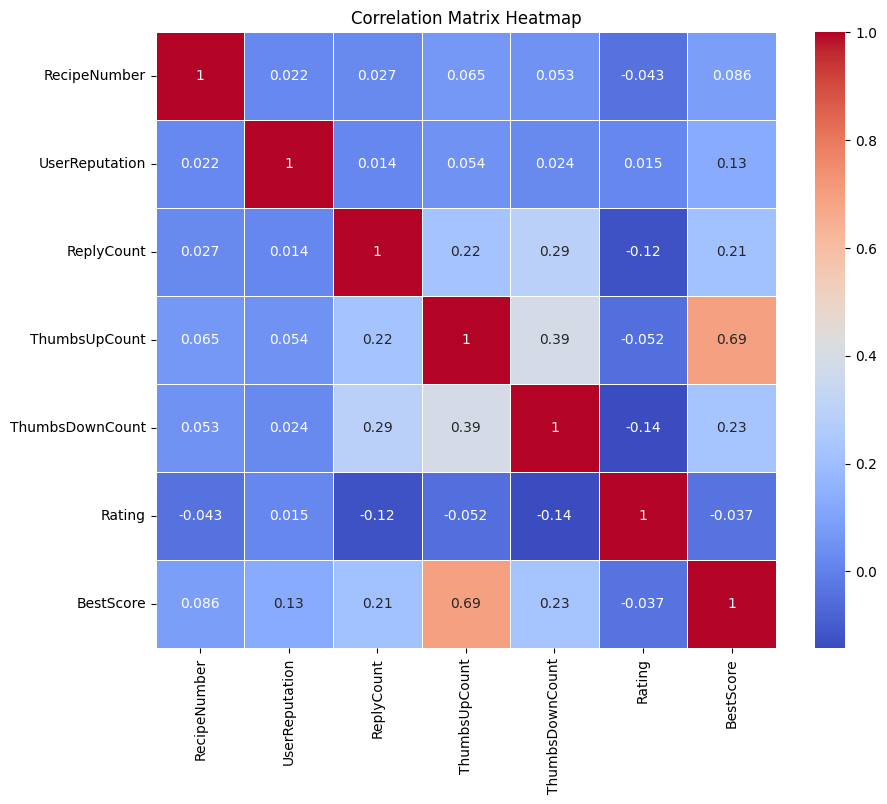

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Key Observations:**

1) **Rating** column has positive correlation with **UserReputation** and negative correlation with other columns **RecipeNumber, ReplyCount,ThumbsUpCount,BestScore** although the association is very small.

2) We can see some hints of multicollinearity between **BestScore and ThumbsUpCount.**



#### **Univariate and Bivariate Analysis**

In [16]:
vars = ['ReplyCount','ThumbsUpCount','ThumbsDownCount','Rating']

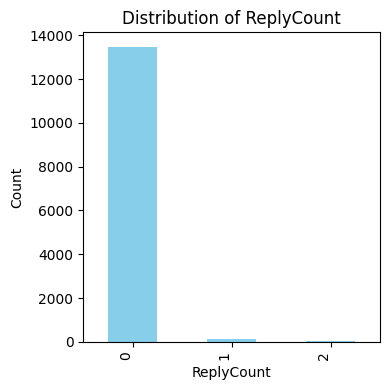

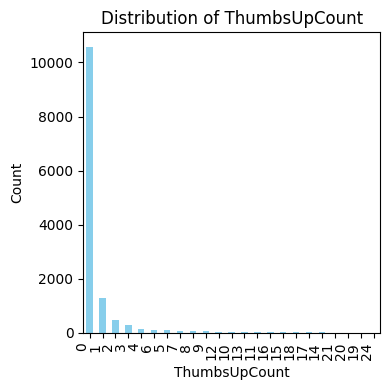

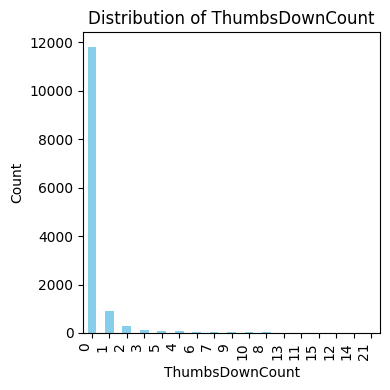

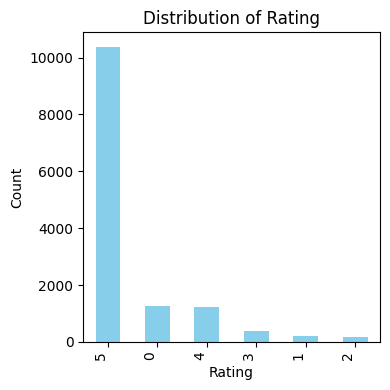

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

min_frequency = 10

for feature in vars:

    value_counts = df[feature].value_counts(dropna=True)
    filtered_counts = value_counts[value_counts >= min_frequency]

    # Create bar chart
    plt.figure(figsize=(4, 4))
    plt.xticks(rotation=45, ha='right')
    plt.xlim(-0.5, len(filtered_counts) - 0.5)

    filtered_counts.plot(kind='bar', color='skyblue')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()      ##Drop the column

We can notice that the data is highly imbalanced, with 10,000+ cases for 5 rating, and much lesser for other categories.

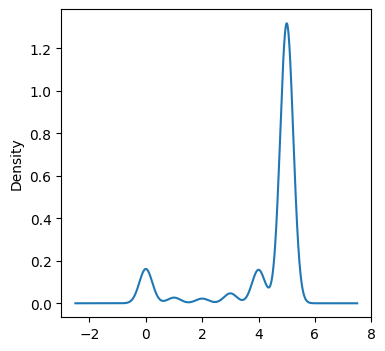

In [18]:
# Create density plots for each variable
df['Rating'].plot.kde(figsize=(4, 4))
plt.show()

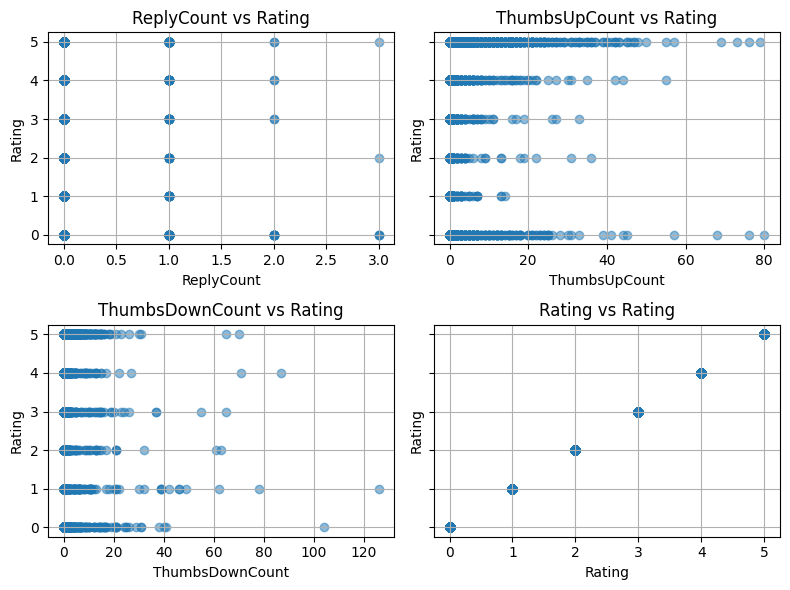

In [19]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharey=True)

for idx, var in enumerate(vars):
    row = idx // 2
    col = idx % 2
    axes[row, col].scatter(df[var], df['Rating'], alpha=0.5)
    axes[row, col].set_title(f'{var} vs Rating')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Rating')
    axes[row, col].grid(True)


plt.tight_layout()
plt.show()


**Hypothesis Testing**

In [20]:

# Does the Rating Column has any association with ThumbsUpCount?
#Null Hypothesis: Rating Column does not have any association with ThumbsUpCount

ThumbsUp_Rating_table = pd.crosstab(df['Rating'], df['ThumbsUpCount'])
print(ThumbsUp_Rating_table)


ThumbsUpCount    0    1    2    3    4   5   6   7   8   9   ...  48  50  55  \
Rating                                                       ...               
0               949  103   44   28   14  16  15  17   4   6  ...   0   0   0   
1               142   41    6    9    1   3   1   4   0   0  ...   0   0   0   
2               117   23   10    6    6   1   1   0   1   2  ...   0   0   0   
3               257   48   24   10    6   1   6   3   3   1  ...   0   0   0   
4               969  125   45   15   14  11  14   5   7   2  ...   0   0   1   
5              8148  950  349  211  114  78  80  48  43  45  ...   1   1   1   

ThumbsUpCount  57  68  69  73  76  79  80  
Rating                                     
0               1   1   0   0   1   0   1  
1               0   0   0   0   0   0   0  
2               0   0   0   0   0   0   0  
3               0   0   0   0   0   0   0  
4               0   0   0   0   0   0   0  
5               1   0   1   1   1   1   0  

[6 row

In [21]:
ThumbsUp_Rating_table = pd.crosstab(df['Rating'], df['UserReputation'])
ThumbsUp_Rating_table

UserReputation,0,1,10,20,30,40,50,60,70,80,90,100,110,130,140,150,160,220,300,510
Rating,,,,,,,,,,,,,,,,,,,,
0,14,1215,28,3,7,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,4,195,9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3,159,9,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,341,14,7,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,10,1144,47,25,6,2,3,0,0,1,0,0,0,0,1,0,1,1,0,0
5,85,9654,371,179,38,7,13,4,1,3,5,1,3,1,1,1,0,0,1,3


We can notice that dishes with higher thumbs up count tend to have higher ratings too. We can perform chi-square test to check its statistical significance.

In [22]:
import pandas as pd
from scipy.stats import chi2_contingency

# Perform chi-square test
chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(ThumbsUp_Rating_table.values)

# Print the test results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {pval:.4f}")

# Interpretation
if pval < 0.05:
    print("Reject null hypothesis: There is a statistically significant association between Rating and ThumbsUpCount.")
else:
    print("Fail to reject null hypothesis: There is not enough evidence to conclude a statistically significant association between Rating and ThumbsUpCount.")



Chi-square statistic: 120.24
p-value: 0.0411
Reject null hypothesis: There is a statistically significant association between Rating and ThumbsUpCount.


Let's check associations between other variables and Rating columnn too.

In [23]:
ThumbsDown_Rating_table = pd.crosstab(df['Rating'], df['ThumbsDownCount'])
print(ThumbsDown_Rating_table)

# Does the Rating Column has any association with ThumbsDownCount?
#Null Hypothesis: Rating Column does not have any association with ThumbsDownCount

chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(ThumbsDown_Rating_table.values)

# Print the test results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {pval:.4f}")

# Interpretation
if pval < 0.05:
    print("Reject null hypothesis: There is a statistically significant association between Rating and ThumbsDownCount.")
else:
    print("Fail to reject null hypothesis: There is not enough evidence to conclude a statistically significant association between Rating and ThumbsDownCount.")

ThumbsDownCount   0    1    2    3    4    5    6    7    8    9    ...  61   \
Rating                                                              ...        
0                1045   80   44   15   14    8   10    8    3    5  ...    0   
1                  99   26   13    6   10    6   12    3    3    1  ...    0   
2                  95   30   13    6    3    5    2    0    1    2  ...    1   
3                 248   50   19   12    3    6    0    3    1    1  ...    0   
4                1044  105   35   16    8    7    1    2    3    5  ...    0   
5                9285  621  168   88   40   48   27   20   12   11  ...    0   

ThumbsDownCount  62   63   65   70   71   78   87   104  126  
Rating                                                        
0                  0    0    0    0    0    0    0    1    0  
1                  1    0    0    0    0    1    0    0    1  
2                  0    1    0    0    0    0    0    0    0  
3                  0    0    1    0    0    

In [24]:


ReplyCount_Rating_table = pd.crosstab(df['Rating'], df['ReplyCount'])
print(ReplyCount_Rating_table)

# Does the Rating Column has any association with ReplyCount?
#Null Hypothesis: Rating Column does not have any association with ReplyCount

# Perform chi-square test
chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(ReplyCount_Rating_table.values)

# Print the test results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {pval:.4f}")

# Interpretation
if pval < 0.05:
    print("Reject null hypothesis: There is a statistically significant association between Rating and ReplyCount.")
else:
    print("Fail to reject null hypothesis: There is not enough evidence to conclude a statistically significant association between Rating and ReplyCount.")

ReplyCount      0   1   2  3
Rating                      
0            1216  43  10  3
1             197  13   0  0
2             164   9   0  1
3             353  13   2  0
4            1223  16   2  0
5           10311  57   2  1
Chi-square statistic: 279.88
p-value: 0.0000
Reject null hypothesis: There is a statistically significant association between Rating and ReplyCount.


In [25]:


# Perform chi-square test
chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(ThumbsDown_Rating_table.values)

# Print the test results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {pval:.4f}")

# Interpretation
if pval < 0.05:
    print("Reject null hypothesis: There is a statistically significant association between Rating and ThumbsDownCount.")
else:
    print("Fail to reject null hypothesis: There is not enough evidence to conclude a statistically significant association between Rating and ThumbsDownCount.")

Chi-square statistic: 2554.23
p-value: 0.0000
Reject null hypothesis: There is a statistically significant association between Rating and ThumbsDownCount.


#### **Feature Engineering**

Data Cleaning

Dropping Redundant Columns

Handling Text Data

Feature Scaling


**Data Cleaning**

In [26]:
df.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

We can see that **Recipe_Review** has 2 null values.

In [27]:
df.dropna(inplace=True)

In [28]:
df.shape

(13634, 15)

**Dropping Redundant Columns**

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13634 non-null  int64 
 1   RecipeNumber       13634 non-null  int64 
 2   RecipeCode         13634 non-null  int64 
 3   RecipeName         13634 non-null  object
 4   CommentID          13634 non-null  object
 5   UserID             13634 non-null  object
 6   UserName           13634 non-null  object
 7   UserReputation     13634 non-null  int64 
 8   CreationTimestamp  13634 non-null  int64 
 9   ReplyCount         13634 non-null  int64 
 10  ThumbsUpCount      13634 non-null  int64 
 11  ThumbsDownCount    13634 non-null  int64 
 12  Rating             13634 non-null  int64 
 13  BestScore          13634 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.7+ MB


In [30]:
df.drop(columns=['ID','RecipeNumber','RecipeCode','CommentID','UserID','UserName','CreationTimestamp'],inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 0 to 13635
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   RecipeName       13634 non-null  object
 1   UserReputation   13634 non-null  int64 
 2   ReplyCount       13634 non-null  int64 
 3   ThumbsUpCount    13634 non-null  int64 
 4   ThumbsDownCount  13634 non-null  int64 
 5   Rating           13634 non-null  int64 
 6   BestScore        13634 non-null  int64 
 7   Recipe_Review    13634 non-null  object
dtypes: int64(6), object(2)
memory usage: 958.6+ KB


**Feature Scaling, Handling Text Data using Column Transformer**

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


In [33]:
ct = ColumnTransformer([
     ("Scaler", StandardScaler(),
     ["UserReputation", "ReplyCount", "ThumbsUpCount", "ThumbsDownCount", "BestScore"]),
     ("vectoriser", TfidfVectorizer(),"RecipeName"),
    ("vectoriser2", TfidfVectorizer(),"Recipe_Review")
    ]
)

**Train Val Splitting**

In [34]:
y=df[['Rating']]
y

,Rating
0,5
1,5
2,3
3,5
4,4
...,...
13631,5
13632,5
13633,5
13634,5


In [35]:
X=  df.drop(columns='Rating')
X

,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,Banana Bars with Cream Cheese Frosting,20,0,0,0,100,great recipe! I have made them just as written...
1,Simple Taco Soup,1,0,0,1,100,This is an easy and quick recipe that is great...
2,Cheeseburger Soup,1,0,0,0,100,I think I was looking for something extra spec...
3,Grilled Huli Huli Chicken,1,0,0,0,100,This is our favorite grilled chicken recipe. ...
4,Cauliflower Soup,1,0,0,0,100,Great basic recipe. I added 2 teaspoons Tuscan...
...,...,...,...,...,...,...,...
13631,Quick Cream of Mushroom Soup,1,0,0,0,100,Delicious!! Very easy to make! One minor chang...
13632,Favorite Chicken Potpie,1,0,0,0,100,I made this pie for my family and they loved i...
13633,Taco Lasagna,1,0,0,0,100,Very tasty!
13634,Chicken and Dumplings,1,0,0,0,100,I have made this numerous times. It&#39;s so ...


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [37]:
y_train.value_counts()

Rating
5         8295
0         1018
4          993
3          294
1          168
2          139
Name: count, dtype: int64

In [38]:
y_train

,Rating
10795,5
7527,5
5299,0
6579,5
477,5
...,...
5903,5
9452,0
8706,5
6807,5


In [39]:
y_train = y_train.values.ravel()

**Base Model: Logistic Regression**

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
lr_clf=LogisticRegression(random_state=42,max_iter=1000)

In [42]:
ml_pipeline1= Pipeline(
    [
        ("preprocessing", ct),
        ("lr", lr_clf),
    ]
)

In [43]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (10907, 7)
Shape of y_train: (10907,)


In [44]:
ml_pipeline1.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [45]:
ml_pipeline1.score(X_val,y_val)

0.7719105243857719

**Error Analysis using cross validation**

In [46]:
from sklearn.model_selection import cross_val_score,cross_val_predict,RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix


In [47]:
y_train_LR_pred= cross_val_predict(ml_pipeline1,X_train,y_train,cv=3)

In [48]:
conf_mx_lr=confusion_matrix(y_train,y_train_LR_pred)

In [49]:
confusion_matrix(y_train,y_train_LR_pred)

array([[ 157,    9,    0,    9,   18,  825],
       [  24,   16,    2,   13,    4,  109],
       [   9,    3,    0,   16,   29,   82],
       [  20,    6,    3,   20,   42,  203],
       [  26,    0,    2,    8,   93,  864],
       [  82,    2,    0,    3,   65, 8143]])

**Model Evaluation on Val Set**

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
y_val_predictLR=ml_pipeline1.predict(X_val)

In [52]:
LR_val_acc=accuracy_score(y_val,y_val_predictLR)
LR_val_acc

0.7719105243857719

**HyperParameter Tuning**

In [53]:
from sklearn.model_selection import GridSearchCV


In [54]:
param_grid_lr = {
     'lr__C': [0.01, 0.1, 1],
    'lr__solver': ['lbfgs', 'newton-cg','liblinear'],
}

In [55]:
grid_search_lr=GridSearchCV(estimator=ml_pipeline1,param_grid=param_grid_lr,cv=5,scoring="accuracy")

In [56]:
grid_search_lr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('Scaler',
                                                                         StandardScaler(),
                                                                         ['UserReputation',
                                                                          'ReplyCount',
                                                                          'ThumbsUpCount',
                                                                          'ThumbsDownCount',
                                                                          'BestScore']),
                                                                        ('vectoriser',
                                                                         TfidfVectorizer(),
                                                                         'RecipeName'),
                                                                        ('vectoriser2',
                                                                         TfidfVectorizer(),
                                                                         'Recipe_Review')])),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'lr__C': [0.01, 0.1, 1],
                         'lr__solver': ['lbfgs', 'newton-cg', 'liblinear']},
             scoring='accuracy')

In [57]:
best_params_lr=grid_search_lr.best_params_
best_params_lr

{'lr__C': 1, 'lr__solver': 'lbfgs'}

In [58]:
grid_search_lr.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('lr',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [59]:
cvres=grid_search_lr.cv_results_
for accuracy,params in zip(cvres["mean_test_score"],cvres["params"]):
  print(accuracy,params)

0.7619878115766067 {'lr__C': 0.01, 'lr__solver': 'lbfgs'}
0.7619878115766067 {'lr__C': 0.01, 'lr__solver': 'newton-cg'}
0.7621711296334353 {'lr__C': 0.01, 'lr__solver': 'liblinear'}
0.7638212863279275 {'lr__C': 0.1, 'lr__solver': 'lbfgs'}
0.7638212863279275 {'lr__C': 0.1, 'lr__solver': 'newton-cg'}
0.7627211678562168 {'lr__C': 0.1, 'lr__solver': 'liblinear'}
0.7735407575885564 {'lr__C': 1, 'lr__solver': 'lbfgs'}
0.7734490985601421 {'lr__C': 1, 'lr__solver': 'newton-cg'}
0.7712484413552423 {'lr__C': 1, 'lr__solver': 'liblinear'}


In [60]:
lr_clf_tuned=LogisticRegression(random_state=42,C=1,solver='lbfgs',penalty='l2',max_iter=1000)

In [61]:
lr_pipeline_tuned= Pipeline(
    [
        ("preprocessing", ct),
        ("lr", lr_clf_tuned),
    ]
)

In [62]:
lr_pipeline_tuned.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('lr',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [63]:
from sklearn.metrics import f1_score

In [64]:
y_val_predict_lr=lr_pipeline_tuned.predict(X_val)

In [65]:
LR_acc_score_val=accuracy_score(y_val,y_val_predict_lr)
LR_acc_score_val

0.7719105243857719

In [66]:
LR_f1_score_val=f1_score(y_val,y_val_predict_lr,average='weighted')
LR_f1_score_val

0.7153060234458863

In [67]:
conf_matrix_lr=confusion_matrix(y_val,y_val_predict_lr)
conf_matrix_lr

array([[  47,    3,    1,    3,    3,  197],
       [   2,    7,    0,    0,    2,   31],
       [   2,    9,    0,    0,    5,   19],
       [   5,    1,    1,    6,   15,   46],
       [  13,    1,    1,    3,   25,  205],
       [  28,    0,    0,    1,   25, 2020]])

**Applying Ridge Classifier**

In [68]:
from sklearn.linear_model import RidgeClassifierCV

In [69]:
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge_clf", RidgeClassifierCV(alphas=[0.1, 1.0,10.0], cv=3))
])

In [70]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('ridge_clf',
                 RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=3))])

In [71]:
y_pred_ridge = ridge_pipeline.predict(X_val)

In [72]:
accuracy_ridge = accuracy_score(y_val, y_pred_ridge)
print("Ridge Classifier Accuracy:", accuracy_ridge)

Ridge Classifier Accuracy: 0.7733773377337734


In [73]:
conf_matrix_ridge = confusion_matrix(y_val, y_pred_ridge)
print("Confusion Matrix:")
print(conf_matrix_ridge)

Confusion Matrix:
[[  56    2    0    1    3  192]
 [   2    8    0    2    2   28]
 [   1    3    1    2    7   21]
 [   5    0    1    4   13   51]
 [  11    1    0    2   16  218]
 [  31    2    0    0   17 2024]]


**Applying KNN**

In [74]:
from sklearn.neighbors import KNeighborsClassifier

In [75]:
knn = KNeighborsClassifier()

In [76]:
knn_pipeline= Pipeline(
    [
        ("preprocessing", ct),
        ("knn", knn),
    ]
)

In [77]:
# param_grid_knn = {'knn__n_neighbors': [5,10,14],'knn__metric': ['euclidean', 'manhattan']}

In [78]:
#param_grid_knn = {'n_neighbors': range(1,20)}

In [79]:
# grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid_knn, cv=3,scoring="accuracy")

In [80]:
# grid_search_knn.fit(X_train, y_train)

In [81]:
knn = KNeighborsClassifier(n_neighbors=14,weights='distance',metric='manhattan')

In [82]:
knn_pipeline= Pipeline(
    [
        ("preprocessing", ct),
        ("knn", knn),
    ]
)

In [83]:
knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=14,
                                      weights='distance'))])

In [84]:
acc_scores_knn_train = cross_val_score(knn_pipeline, X_train, y_train, cv=3, scoring='accuracy')
acc_scores_knn_train

array([0.76622662, 0.76512651, 0.7656121 ])

In [85]:
y_val_predict_knn=knn_pipeline.predict(X_val)

In [86]:
acc_score_knn_val=accuracy_score(y_val,y_val_predict_knn)
acc_score_knn_val

0.7719105243857719

**Applying SVM Model**

In [87]:
from sklearn.svm import SVC

In [88]:
svm = SVC()

In [89]:
svm_pipeline= Pipeline(
    [
        ("preprocessing", ct),
        ("svm", svm),
    ]
)

In [90]:
param_grid_svm = {'svm__C': [0.01,0.1,1]}  #best value for C= 1

In [91]:
grid_search_svm=GridSearchCV(estimator=svm_pipeline, param_grid=param_grid_svm, cv=3,scoring="accuracy")

`

In [92]:
grid_search_svm.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('Scaler',
                                                                         StandardScaler(),
                                                                         ['UserReputation',
                                                                          'ReplyCount',
                                                                          'ThumbsUpCount',
                                                                          'ThumbsDownCount',
                                                                          'BestScore']),
                                                                        ('vectoriser',
                                                                         TfidfVectorizer(),
                                                                         'RecipeName'),
                                                                        ('vectoriser2',
                                                                         TfidfVectorizer(),
                                                                         'Recipe_Review')])),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.01, 0.1, 1]}, scoring='accuracy')

In [93]:
grid_search_svm.best_params_

{'svm__C': 1}

In [94]:
#svm_rbf= SVC(kernel='rbf',C= 1, coef0= 0,gamma=0.1) #f1=0.7705718097220183 mean cv score best score svm_rb

In [95]:
svm= SVC(kernel='linear',C= 1, probability=True)

In [96]:
svm_pipeline= Pipeline(
    [
        ("preprocessing", ct),
        ("svm", svm),
    ]
)

**Performance Evaluation**

In [97]:
acc_svm_train = cross_val_score(svm_pipeline, X_train, y_train, cv=3, scoring='accuracy')
acc_svm_train

array([0.77365237, 0.77310231, 0.7738652 ])

In [98]:
import sklearn

In [99]:
svm_pipeline.fit(X_train,y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('svm', SVC(C=1, kernel='linear', probability=True))])

In [100]:
y_val_predict_svm=svm_pipeline.predict(X_val)

In [101]:
acc_svm_val=accuracy_score(y_val,y_val_predict_svm)
acc_svm_val

0.7792445911257793

In [102]:
conf_mat_svm_val=confusion_matrix(y_val,y_val_predict_svm)
conf_mat_svm_val

array([[  44,    5,    1,    0,    1,  203],
       [   3,   11,    0,    2,    1,   25],
       [   2,    8,    2,    1,    0,   22],
       [   4,    2,    3,   10,    3,   52],
       [   9,    1,    1,    6,    7,  224],
       [  18,    0,    0,    1,    4, 2051]])

**Appling CART (Decision Tree)**

In [103]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [104]:
cart_model = DecisionTreeClassifier()

In [105]:
cart_pipeline = Pipeline([
    ('preprocessing', ct),
    ('cart_model', cart_model)
])

In [106]:
cart_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('cart_model', DecisionTreeClassifier())])

In [107]:
# param_grid_cart= {
#     'cart_model__max_depth': [7,5],
#     'cart_model__min_samples_split': [5,10,8],
#     'cart_model__min_samples_leaf': [10,9,8]}

In [108]:
# grid_search_cart = GridSearchCV(estimator=cart_pipeline, cv=3,param_grid=param_grid_cart,scoring="f1_weighted")

In [109]:
# grid_search_cart.fit(X_train,y_train)

In [110]:
# grid_search_cart.best_params_

In [111]:
cart_model = DecisionTreeClassifier(criterion= "entropy", max_depth= 7,min_samples_leaf =9,min_samples_split= 5)

In [112]:
cart_pipeline = Pipeline([
    ('preprocessing', ct),
    ('cart_model', cart_model)
])

In [113]:
cart_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('cart_model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        min_samples_leaf=9,
                                        min_samples_split=5))])

In [114]:
y_val_predict_cart=cart_pipeline.predict(X_val)

In [115]:
acc_score_cart_val=accuracy_score(y_val,y_val_predict_cart)
acc_score_cart_val

0.7502750275027503

#### **Ensemble Techniques**

**1)Random Forest: Bagging**

**2)Xg_boost: Boosting**

**3)Logistic Regression Bagging Classifier: Bagging**

**4)Voting Classifier: Voting**

**5)Ada Boosting: Boosting**

**6)Gradient Boosting: Boosting**

**7)Stacking Classifier: Stacking**

**1) Random Forest**

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
rf_clf = RandomForestClassifier()


In [118]:
rf_pipeline = Pipeline([
    ('preprocessing', ct),
    ('rf_clf', rf_clf)
])

In [119]:
# param_grid_rf={'rf_clf__max_depth': [3,5,7],
# 'rf_clf__min_samples_split': [6,10,14 ],
# "rf_clf__n_estimators": [15,25,50,100],
#     'rf_clf__min_samples_leaf': [6,8,10]}

In [120]:
# grid_search_rf= GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, cv=3, scoring="accuracy")


In [121]:
# grid_search_rf.fit(X_train, y_train)

In [122]:
# grid_search_rf.best_params_

In [123]:
rf_clf = RandomForestClassifier(n_estimators=15,max_depth=7,min_samples_split=6,min_samples_leaf=8,random_state=0)

In [124]:
rf_pipeline = Pipeline([
    ('preprocessing', ct),
    ('rf_clf', rf_clf)
])

In [125]:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('rf_clf',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=8,
                                        min_samples_split=6, n_estimators=15,
                                        random_state=0))])

In [126]:
y_val_pred_rf= rf_pipeline.predict(X_val)

In [127]:
acc_random_forest=accuracy_score(y_val,y_val_pred_rf)
acc_random_forest

0.7605427209387605

In [128]:
cm_fr=confusion_matrix(y_val,y_val_pred_rf)
cm_fr

array([[   0,    0,    0,    0,    0,  254],
       [   0,    0,    0,    0,    0,   42],
       [   0,    0,    0,    0,    0,   35],
       [   0,    0,    0,    0,    0,   74],
       [   0,    0,    0,    0,    0,  248],
       [   0,    0,    0,    0,    0, 2074]])

In [129]:
'''feature_importances = rf_pipeline.feature_importances_
feature_importances'''

'feature_importances = rf_pipeline.feature_importances_\nfeature_importances'

In [130]:
'''import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)  # Assuming X_train has feature names
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  #Invert y-axis for readability
plt.show()'''

'import matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 6))\nplt.barh(X_train.columns, feature_importances)  # Assuming X_train has feature names\nplt.xlabel("Feature Importance")\nplt.ylabel("Feature")\nplt.title("Feature Importance in Random Forest Model")\nplt.gca().invert_yaxis()  #Invert y-axis for readability\nplt.show()'

**2) XG Boost**


In [131]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [132]:
xgb_model=xgb.XGBRFClassifier(num_class=5)

In [133]:
xgb_pipeline = Pipeline([
    ('preprocessing', ct),
    ('xgb_model', xgb_model)
])

In [134]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded= le.fit_transform(y_val)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [135]:
# param_grid_xgb = {

#     'xgb_pipeline__learning_rate': [0.05, 0.1,1],
#      'xgb_pipeline__max_depth': [3,6,9],
#     'xgb_pipeline__n_estimators': [50, 100, 200],
#     'xgb_pipeline__subsample': [0.6, 0.8,1.0],
#     'xgb_pipeline__colsample_bytree': [0.6, 0.8, 1.0]
# }

In [136]:
# grid_search_xgb= GridSearchCV(
#     estimator=xgb_pipeline,
#     param_grid=param_grid_xgb,
#     cv=3,
#     scoring='accuracy',
#     verbose=2,
#     n_jobs=-1
# )

In [137]:
#grid_search_xgb.fit(X_train,y_train_encoded)

In [138]:
# best_params_xgb = grid_search_xgb.best_params_
# best_params_xgb

In [139]:
# best_model_xgb = grid_search_xgb.best_estimator_
# best_model_xgb

In [140]:
xgb_model = xgb.XGBRFClassifier(
    max_depth=3,   #
    num_class=5,
    learning_rate=0.01,
    n_estimators=50,
    subsample=0.5,
    random_state=42,
    colsample_bytree = 1.0,
    min_child_weight =8,
    multi_strategy= "one_output_per_tree",
    n_jobs=0

)

In [141]:
xgb_pipeline = Pipeline([
    ('preprocessing', ct),
    ('xgb_model', xgb_model)
])

In [142]:
xgb_pipeline.fit(X_train,y_train_encoded)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  ['UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'BestScore']),
                                                 ('vectoriser',
                                                  TfidfVectorizer(),
                                                  'RecipeName'),
                                                 ('vectoriser2',
                                                  TfidfVectorizer(),
                                                  'Recipe_Review')])),
                ('xgb_model',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsamp...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=0.01, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=3,
                                 max_leaves=None, min_child_weight=8,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy='one_output_per_tree',
                                 n_estimators=50, n_jobs=0, num_class=5,
                                 num_parallel_tree=None,
                                 objective='multi:softprob', ...))])

In [143]:
y_val_xgb_pred =xgb_pipeline.predict(X_val)

In [144]:
accuracy_xgb = accuracy_score(y_val_encoded, y_val_xgb_pred)
print("Accuracy:", accuracy_xgb)

Accuracy: 0.7623762376237624


In [145]:
conf_matrix_xgb = confusion_matrix(y_val_encoded, y_val_xgb_pred)
conf_matrix_xgb

array([[   1,    0,    0,    0,    0,  253],
       [   0,    4,    0,    0,    0,   38],
       [   0,    3,    0,    0,    0,   32],
       [   0,    2,    0,    0,    0,   72],
       [   0,    1,    0,    0,    0,  247],
       [   0,    0,    0,    0,    0, 2074]])

**3) LR Bagging Classifier**

In [146]:
from sklearn.ensemble import BaggingClassifier


lr= LogisticRegression(random_state=42,C=1,solver='lbfgs',max_iter=1000)

# Create bagging classifier with logistic regression as base estimator
lr_bagging_clf = BaggingClassifier(
    base_estimator=lr,
    n_estimators=20,  # Number of base estimators in the ensemble
    max_samples=0.5,
    max_features=1.0,  # Feature size for each base estimator (1.0 means all features)
    bootstrap=True,  # Whether to sample with replacement
    random_state=42,  # Random seed for reproducibility
    n_jobs=-1,  # Number of CPU cores to use (-1 for all cores)
)

lr_bagging_pipeline= Pipeline(
    [
        ("preprocessing", ct),
        ("lr_bagging_clf", lr_bagging_clf),
    ]
)

lr_bagging_pipeline.fit(X_train, y_train)
y_val_pred_lr_bag = lr_bagging_pipeline.predict(X_val)

accuracy_lr_baggging= accuracy_score(y_val, y_val_pred_lr_bag)
print("Accuracy_lr_baggging:", accuracy_lr_baggging)


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy_lr_baggging: 0.7675100843417675


**4) Voting Classifier**

In [147]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('knn', knn_pipeline),
        ('lr', lr_pipeline_tuned),
        ('svm', svm_pipeline)
    ],
    voting='hard'  # Use 'hard' voting for majority rule voting
)

# Fit the Voting Classifier on the training data
voting_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_voting = voting_classifier.predict(X_val)

# Calculate accuracy
accuracy_voting = accuracy_score(y_val, y_pred_voting)
print("Voting Classifier Accuracy:", accuracy_voting)


Voting Classifier Accuracy: 0.7766776677667767


**5) Ada Boost**

In [148]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_clf = AdaBoostClassifier(n_estimators=100, random_state=42,learning_rate=1.0)

ada_boost_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ada_boost_clf", ada_boost_clf)
])

ada_boost_pipeline.fit(X_train, y_train)

y_pred_ada_boost = ada_boost_pipeline.predict(X_val)

accuracy_ada_boost = accuracy_score(y_val, y_pred_ada_boost)
print("AdaBoost Classifier Accuracy:", accuracy_ada_boost)


AdaBoost Classifier Accuracy: 0.7642097543087643


**6) Gradient Boost**

In [149]:

param_grid_gb= {
    'n_estimators': [100,150,200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [ 5, 7],
    'min_samples_split': [8,10,12],
    'min_samples_leaf': [6,8,12],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42]
}

In [150]:
from sklearn.ensemble import GradientBoostingClassifier


gradient_boost_clf = GradientBoostingClassifier(n_estimators=150, random_state=42,learning_rate=0.1,max_depth=7,min_samples_split=12,subsample=0.8,min_samples_leaf=10)


gradient_boost_pipeline = Pipeline([
    ("preprocessing", ct),
    ("gradient_boost_clf", gradient_boost_clf)
])






In [151]:
gradient_boost_pipeline.fit(X_train, y_train)
y_pred_gradient_boost = gradient_boost_pipeline.predict(X_val)


accuracy_gradient_boost = accuracy_score(y_val, y_pred_gradient_boost)
print("Gradient Boosting Classifier Accuracy:", accuracy_gradient_boost)

Gradient Boosting Classifier Accuracy: 0.7788778877887789


In [152]:

conf_matrix_gradient_boost = confusion_matrix(y_val, y_pred_gradient_boost)
conf_matrix_gradient_boost

array([[  52,    2,    0,    4,    2,  194],
       [   4,    8,    2,    4,    2,   22],
       [   3,    3,    7,    2,    3,   17],
       [   3,    0,    2,   12,    9,   48],
       [   9,    2,    1,    4,   27,  205],
       [  29,    1,    2,    2,   22, 2018]])

We can notice the diagonal in both the confusion matrix which represents the number of correct predictions and observe:

1) Gradient boosting is generalising better for all the ratings, not just the majority class.

**7) Stacking Classifier**

In [153]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators = [
    ('svm',svm_pipeline),
    ('ridge',ridge_pipeline),
    ('lr',lr_pipeline_tuned),
    ('knn',knn_pipeline),
    ('rf',rf_pipeline),
]
stack_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=42,max_iter=1000),cv=3
)

stack_clf.fit(X_train, y_train)
y_pred_val_stack=stack_clf.predict(X_val)

accuracy_stack=accuracy_score(y_val,y_pred_val_stack)
print("Accuracy score for stack_clf is:",accuracy_stack)

Accuracy score for stack_clf is: 0.7821782178217822


In [154]:
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier

# estimators = [
#     ('svm',svm_pipeline),
#     ('gb',gradient_boost_pipeline),
# ]
# stack_clf = StackingClassifier(
#     estimators=estimators, final_estimator=LogisticRegression(random_state=42)
# )

# stack_clf.fit(X_train, y_train).score(X_val, y_val)

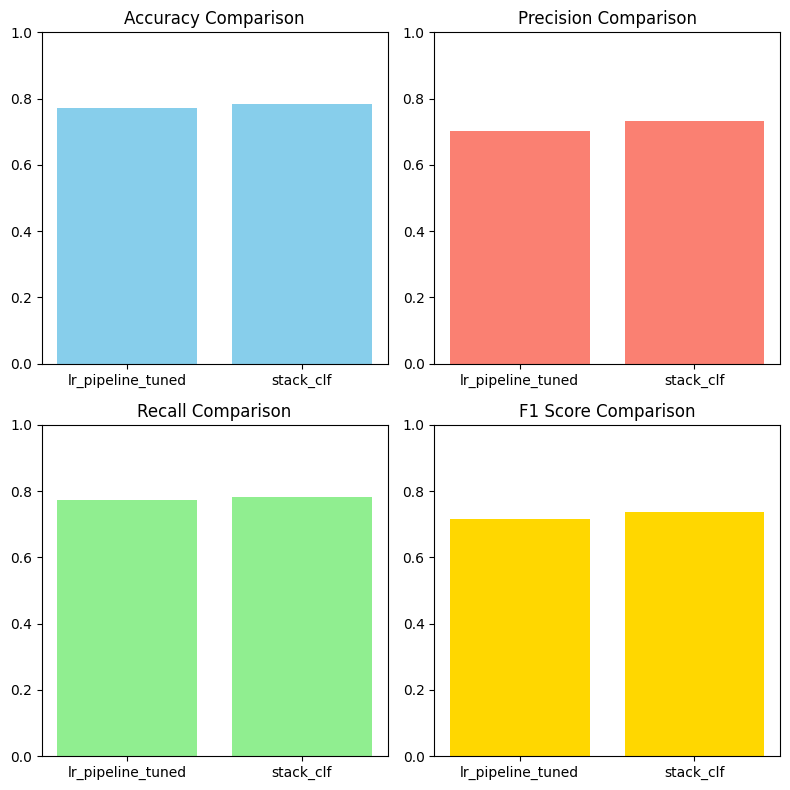

In [155]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_lr = accuracy_score(y_val, y_val_predict_lr)
precision_lr = precision_score(y_val,y_val_predict_lr, average='weighted')
recall_lr = recall_score(y_val, y_val_predict_lr, average='weighted')
f1_lr = f1_score(y_val, y_val_predict_lr, average='weighted')

accuracy_stack = accuracy_score(y_val, y_pred_val_stack)
precision_stack = precision_score(y_val,y_pred_val_stack, average='weighted')
recall_stack = recall_score(y_val,y_pred_val_stack, average='weighted')
f1_stack = f1_score(y_val, y_pred_val_stack, average='weighted')

models = ['lr_pipeline_tuned', 'stack_clf']

# metric scores for both models
accuracy_scores = [accuracy_lr, accuracy_stack]
precision_scores = [precision_lr, precision_stack]
recall_scores = [recall_lr,recall_stack]
f1_scores = [f1_lr, f1_stack]


# Plotting comparison bar chart
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0, 0].bar(models, accuracy_scores, color='skyblue')
ax[0, 0].set_title('Accuracy Comparison')
ax[0, 0].set_ylim([0, 1])

ax[0, 1].bar(models, precision_scores, color='salmon')
ax[0, 1].set_title('Precision Comparison')
ax[0, 1].set_ylim([0, 1])

ax[1, 0].bar(models, recall_scores, color='lightgreen')
ax[1, 0].set_title('Recall Comparison')
ax[1, 0].set_ylim([0, 1])

ax[1, 1].bar(models, f1_scores, color='gold')
ax[1, 1].set_title('F1 Score Comparison')
ax[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

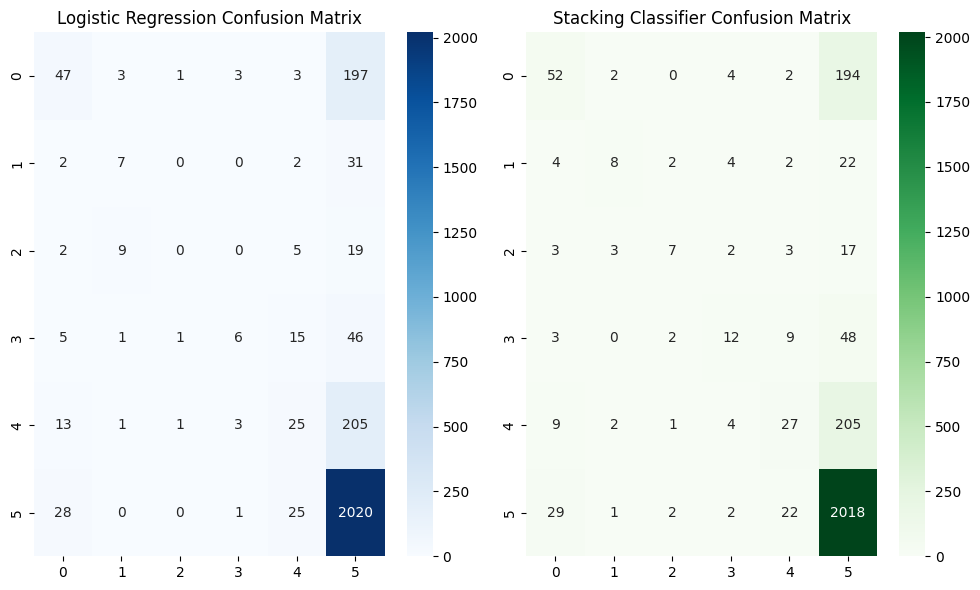

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting heatmaps
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_lr, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_gradient_boost, annot=True, cmap='Greens', fmt='g')
plt.title('Stacking Classifier Confusion Matrix')

plt.tight_layout()
plt.show()


**submission for test set**

In [157]:
df_test=pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

In [158]:
df_test.drop(columns=['ID','RecipeNumber','RecipeCode','CommentID','UserID','UserName','CreationTimestamp'],inplace=True)

In [159]:
X_test=df_test.copy()

**Sample Data**

In [160]:
sample=pd.read_csv(r'/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv')

In [161]:
sample.head()

,ID,Rating
0,1,5
1,2,2
2,3,4
3,4,2
4,5,4


In [162]:
X_test.shape

(4546, 7)

**Logistic Regression test**


In [163]:
#y_test_predict_lr=ml_pipeline1.predict(X_test)

In [164]:
# submission = pd.DataFrame({
#                  "ID" : range(1,4547),
#                  "Rating" : ml_pipeline1.predict(X_test)
# })

**Stacking test**

In [165]:
y_test_predict_stack=stack_clf.predict(X_test)

In [166]:
submission = pd.DataFrame({
                 "ID" : range(1,4547),
                 "Rating" : stack_clf.predict(X_test)
})

In [167]:
submission.head()

,ID,Rating
0,1,5
1,2,5
2,3,5
3,4,1
4,5,5


In [168]:
submission.to_csv("submission.csv", index=False)